In [1]:
%pylab inline
import jax
import jax.numpy as jnp
import jax_cosmo as jc


from numpyro.handlers import seed, condition
import numpyro.distributions as dist

import tensorflow_probability as tfp; tfp = tfp.substrates.jax
tfd= tfp.distributions

import logging
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())
'unset XLA_FLAGS'

from jax.config import config
config.update("jax_enable_x64", True)


import cmasher as cmr
from functools import partial

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sbi_lens.simulator.LogNormal_field import lensingLogNormal

In [3]:
n_z_bins=5
N=128
map_size=5
gals_per_arcmin2=10
sigma_e=0.26

In [4]:
model = partial(lensingLogNormal, N=N,
    map_size=map_size,
    gal_per_arcmin2=gals_per_arcmin2,
    sigma_e=sigma_e,
    model_type=None,
    with_noise=True)

In [5]:
fiducial_model = condition(model, {'omega_c': 0.3, 'sigma_8': 0.8})
sample_map_fiducial = seed(fiducial_model , jax.random.PRNGKey(42))
m_data= sample_map_fiducial()

In [6]:
theta_max=5
EXTENT = (-0.5 * theta_max, 0.5 * theta_max, -0.5 * theta_max, 0.5 * theta_max)
cmap = cmr.eclipse

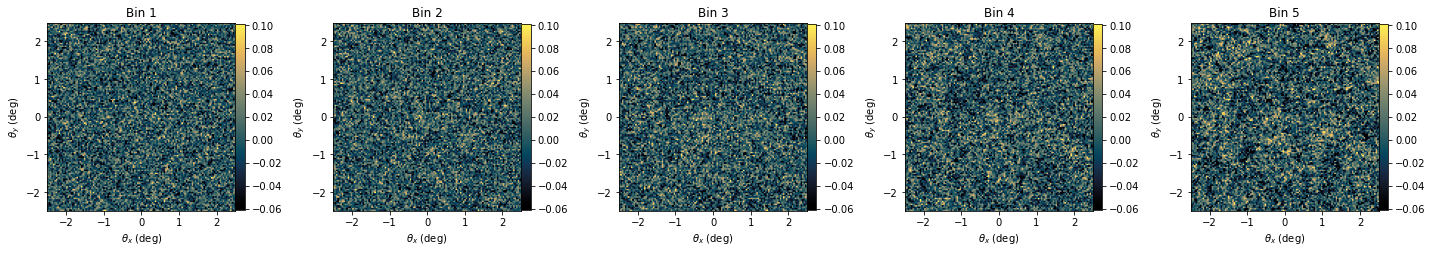

In [7]:
n_nz_bins=5
fig, ax = plt.subplots(1,n_nz_bins, figsize=(4 * n_nz_bins, 7))
for i in range(n_nz_bins):
    std_kmap = np.std(m_data[-1])
    ax[i].set_title('Bin %d'%(i+1))
    ax[i].set_xlabel(r'$\theta_x$ (deg)')
    ax[i].set_ylabel(r'$\theta_y$ (deg)')
    ax[i].imshow(m_data[i], cmap=cmap, vmin = -1.5 * std_kmap, vmax = 2.5 * std_kmap, extent=EXTENT)
    cb = fig.colorbar(ax[i].imshow(m_data[i], cmap=cmap, vmin = -1.5 * std_kmap, vmax = 2.5 * std_kmap, extent=EXTENT) ,fraction=0.047, pad=0.)
    cb.ax.tick_params(labelsize=10)
plt.tight_layout()
plt.show()

In [8]:
with open('map_gaussian_tomo_with_noise.npy','wb') as f:
  save(f, m_data)

## Create fiducial and plot results

In [9]:
from sbi_lens.simulator.utils import get_reference_sample_posterior_full_field, get_reference_sample_posterior_power_spectrum, get_samples_and_scores

In [10]:
samples_ff = get_reference_sample_posterior_full_field(    
    Omega_c=0.3,
    sigma8=0.8,
    run_mcmc=True,
    N=N,
    map_size=map_size,
    gals_per_arcmin2=gals_per_arcmin2,
    sigma_e=sigma_e,
    model=model,
    m_data=m_data,
    num_results=2500,
    key=jax.random.PRNGKey(3))

sample: 100%|██████████| 2600/2600 [3:43:35<00:00,  5.16s/it, 63 steps of size 7.58e-02. acc. prob=0.86]  


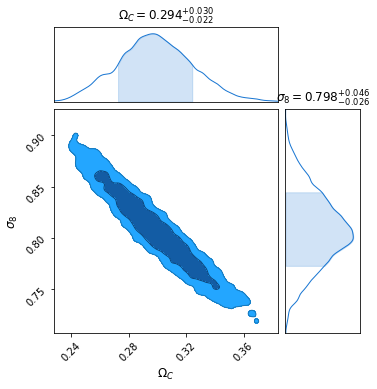

In [11]:
from chainconsumer import ChainConsumer

c = ChainConsumer()

c.add_chain(np.stack([samples_ff[:,0], samples_ff[:,1]],axis=1), parameters=["$\Omega_C$", "$\sigma_8$"], name='Full Field')
fig = c.plotter.plot(figsize="column")



In [14]:
import pickle
with open("posterior_full_field__"
                    "{}N_{}ms_{}gpa_{}se.npy".format(
                       N, map_size, gals_per_arcmin2, sigma_e), "wb") as fp:
    pickle.dump(samples_ff, fp)
